<h1> EDA

<h3> Nesse jupyter notebook iremos analisar os dados de produtos e vendas da VAI Store

Primeiro vamos começar importando as bibliotecas que serão utilizadas ao longo do projeto

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

<h2> Produto

Vamos começar a nossa análise exploratória dos dados com o **produto**

In [2]:
produtos = pd.read_csv('../data/raw/produto.csv', index_col = 0)

In [3]:
produtos.head()

,NOME_PRODUTO,CATEGORIA,SUBCATEGORIA
SKU,,,
3.0,COCO RALADO GROSSO KG ...,Doceria,Confeitaria
4.0,ICE TEA LEAO LATA 340ML ...,NaN,NaN
5.0,TAHINE ISTAMBUL 200G ...,Pelo Mundo,Pastas Árabes
6.0,AMENDOIM MOIDO KG ...,Castanhas & Oleaginosas,Oleaginosas moídas
7.0,HALAWI ISTAMBUL LATA 500G ...,Pelo Mundo,Pastas Árabes


Sumário das colunas:
* SKU = Código do produto 
* NOME_PRODUTO = Descrição do produto 
* CATEGORIA = Categoria do produto 
* SUBCATEGORIA = Subcategoria do produto

Vamos entender qual o número de diferentes produtos que a VAI Store vende

In [4]:
produtos.shape

(6500, 3)

São **6500 produtos diferentes** vendidos. 

Agora vamos entender quais as **principais categorias de produtos** vendidos pela VAI Store

Total de produtos no catálogo: 6500
Total de produtos com categoria definida: 4498
                CATEGORIA  PERCENTUAL
0             Suplementos    7.892397
1              Lanchonete    7.625611
2     Vinhos & Espumantes    6.291685
3              Guloseimas    5.246776
4                 Doceria    4.690974
5                   Natal    4.068475
6    Massas & Panificação    3.935082
7  Temperos & Condimentos    3.779458
8                   Frios    3.557137
9                 Bebidas    3.179191


C:\Users\felip\AppData\Local\Temp\ipykernel_13356\2973083339.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


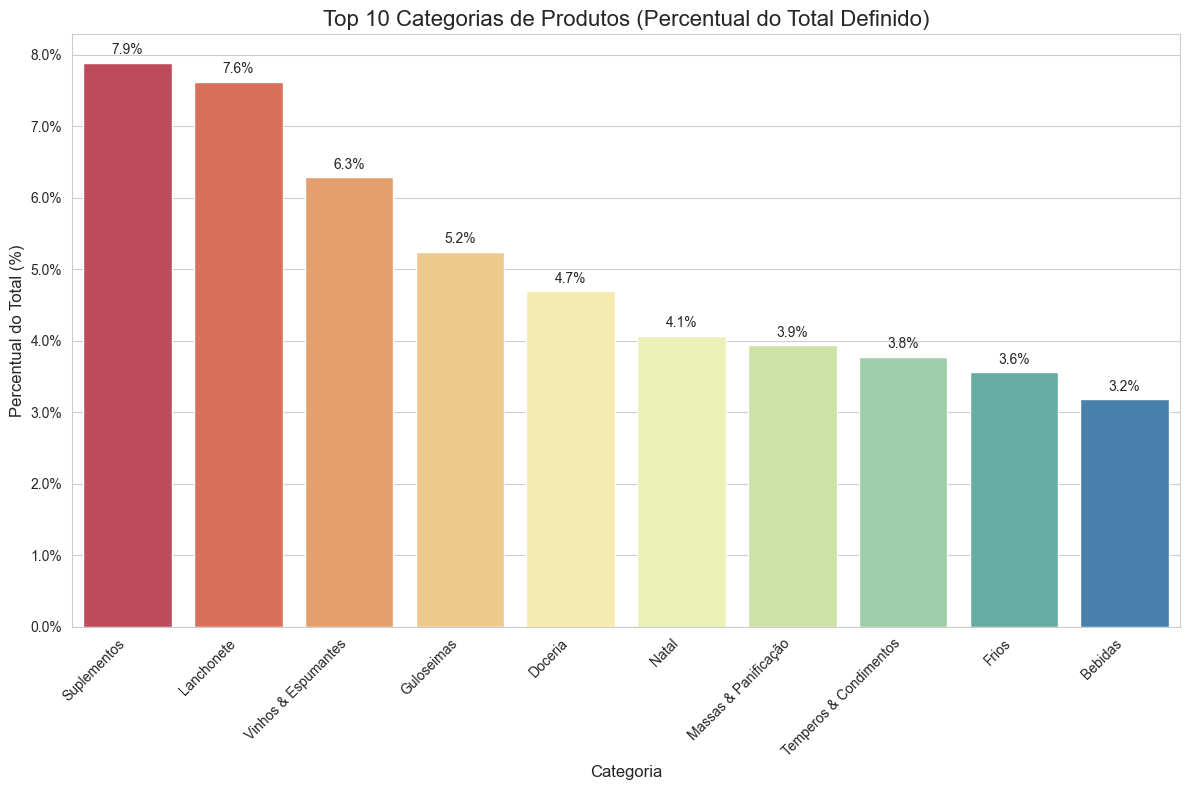

In [10]:
#Configuração inicial
sns.set_style("whitegrid")

# Remover produtos que não possuem categoria (valores NaN)
produtos_clean_categoria = produtos.dropna(subset=['CATEGORIA'])

print(f"Total de produtos no catálogo: {len(produtos)}")
print(f"Total de produtos com categoria definida: {len(produtos_clean_categoria)}")

#Cálculo de Percentuais 
# 1. Contar a frequência de cada categoria e calcular o percentual (normalize=True)
#    Isso usa o total de df_produtos_clean como denominador.
# 2. Selecionar o Top 10
top_10_cat = produtos_clean_categoria['CATEGORIA'].value_counts(normalize=True).head(10)

# 3. Converter a Series para um DataFrame
top_10_df = top_10_cat.reset_index()

# 4. Renomear as colunas
top_10_df.columns = ['CATEGORIA', 'PERCENTUAL']

# 5. Converter o percentual de (0.0 a 1.0) para (0 a 100) para exibição
top_10_df['PERCENTUAL'] = top_10_df['PERCENTUAL'] * 100

print(top_10_df)

#Geração do Gráfico
# 1. Criar a figura (figsize(largura, altura))
plt.figure(figsize=(12, 8))

# 2. Criar o gráfico de barras
#    Os dados já estão ordenados por 'value_counts'
ax = sns.barplot(
    data=top_10_df,
    x='CATEGORIA',
    y='PERCENTUAL',
    palette='Spectral' # Paleta de cores
)

# 3. Adicionar títulos e rótulos
ax.set_title('Top 10 Categorias de Produtos (Percentual do Total Definido)', fontsize=16)
ax.set_xlabel('Categoria', fontsize=12)
ax.set_ylabel('Percentual do Total (%)', fontsize=12)

# 4. Formatar o eixo Y para exibir o símbolo de '%'
#    Usamos FuncFormatter pois os dados já estão na escala 0-100
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# 5. Adicionar os rótulos de dados (percentuais) acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',  # Formato do texto (1 casa decimal)
                   (p.get_x() + p.get_width() / 2., p.get_height()), # Posição (x, y)
                   ha = 'center', va = 'center', # Alinhamento
                   xytext = (0, 9), # Deslocamento vertical de 9 pontos
                   textcoords = 'offset points',
                   fontsize=10)

# 6. Rotacionar os rótulos do eixo X (categorias) para evitar sobreposição
plt.xticks(rotation=45, ha='right')

# 7. Ajustar o layout para garantir que os rótulos não sejam cortados
plt.tight_layout()

# 8. Salvar e exibir o gráfico
plt.savefig('../graphics/top_10_categorias.png') # Salva a imagem
plt.show() # Exibe no notebook
plt.close() # Fecha a figura atual

Após conhecer as principais categorias de produtos vamos analisar as **principais subcategorias**

Total de produtos no catálogo: 6500
Total de produtos com subcategoria definida: 4498
        SUBCATEGORIA  PERCENTUAL
0        Suplementos    3.557137
1             Tintos    3.290351
2  Sucos e refrescos    3.001334
3             Cestas    2.712317
4       Ervas & Chás    2.578924
5          Barrinhas    2.423299
6            Queijos    2.245442
7            Cozinha    2.089818
8       Encapsulados    1.956425
9        Energéticos    1.823032


C:\Users\felip\AppData\Local\Temp\ipykernel_13356\3438568627.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


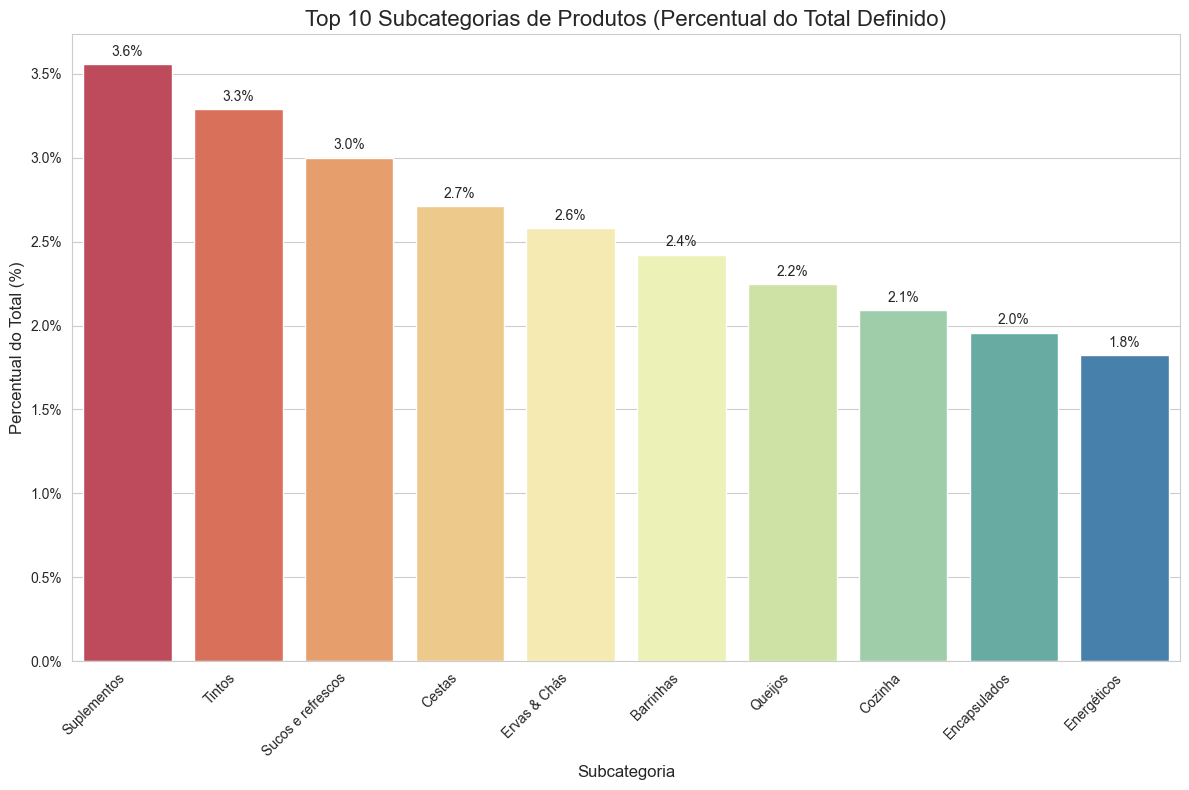

In [11]:
#Configuração inicial
sns.set_style("whitegrid")

# Remover produtos que não possuem categoria (valores NaN)
produtos_clean_subcategoria = produtos.dropna(subset=['SUBCATEGORIA'])

print(f"Total de produtos no catálogo: {len(produtos)}")
print(f"Total de produtos com subcategoria definida: {len(produtos_clean_subcategoria)}")

#Cálculo de Percentuais 
# 1. Contar a frequência de cada categoria e calcular o percentual (normalize=True)
#    Isso usa o total de df_produtos_clean como denominador.
# 2. Selecionar o Top 10
top_10_cat = produtos_clean_subcategoria['SUBCATEGORIA'].value_counts(normalize=True).head(10)

# 3. Converter a Series para um DataFrame
top_10_df = top_10_cat.reset_index()

# 4. Renomear as colunas
top_10_df.columns = ['SUBCATEGORIA', 'PERCENTUAL']

# 5. Converter o percentual de (0.0 a 1.0) para (0 a 100) para exibição
top_10_df['PERCENTUAL'] = top_10_df['PERCENTUAL'] * 100

print(top_10_df)

#Geração do Gráfico
# 1. Criar a figura (figsize(largura, altura))
plt.figure(figsize=(12, 8))

# 2. Criar o gráfico de barras
#    Os dados já estão ordenados por 'value_counts'
ax = sns.barplot(
    data=top_10_df,
    x='SUBCATEGORIA',
    y='PERCENTUAL',
    palette='Spectral' # Paleta de cores
)

# 3. Adicionar títulos e rótulos
ax.set_title('Top 10 Subcategorias de Produtos (Percentual do Total Definido)', fontsize=16)
ax.set_xlabel('Subcategoria', fontsize=12)
ax.set_ylabel('Percentual do Total (%)', fontsize=12)

# 4. Formatar o eixo Y para exibir o símbolo de '%'
#    Usamos FuncFormatter pois os dados já estão na escala 0-100
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))

# 5. Adicionar os rótulos de dados (percentuais) acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',  # Formato do texto (1 casa decimal)
                   (p.get_x() + p.get_width() / 2., p.get_height()), # Posição (x, y)
                   ha = 'center', va = 'center', # Alinhamento
                   xytext = (0, 9), # Deslocamento vertical de 9 pontos
                   textcoords = 'offset points',
                   fontsize=10)

# 6. Rotacionar os rótulos do eixo X (categorias) para evitar sobreposição
plt.xticks(rotation=45, ha='right')

# 7. Ajustar o layout para garantir que os rótulos não sejam cortados
plt.tight_layout()

# 8. Salvar e exibir o gráfico
plt.savefig('../graphics/top_10_subcategorias.png') # Salva a imagem
plt.show() # Exibe no notebook
plt.close() # Fecha a figura atual

Diante as informações acima podemos entender como o pool de produtos da VAI Store está estruturado atualmente

<h2> Vendas

Agora vamos fazer a análise exploratória dos dados para as **vendas**

In [5]:
vendas = pd.read_csv('../data/raw/vendas.csv', index_col = 0, )

In [6]:
vendas.head()

,COD_VENDA,COD_FILIAL,FILIAL,DATA_ATEND,SKU,UNID,QTD_VENDA,FATUR_VENDA,CLI_CPF
COD_ATEND,,,,,,,,,
000304564.299.0101042.20240102,000304564.299.0101042.20240102.000009.02,101042,SHOPPING,2024-01-02,9,KG,0.258,18.04,ec0abf3f4220
000374698.258.0101032.20240102,000374698.258.0101032.20240102.000009.10,101032,RUA,2024-01-02,9,KG,0.064,4.50,83d596ee0acf
000383551.256.0101032.20240102,000383551.256.0101032.20240102.000009.02,101032,RUA,2024-01-02,9,KG,0.164,11.49,46f63c18e055
000383533.256.0101032.20240102,000383533.256.0101032.20240102.000009.02,101032,RUA,2024-01-02,9,KG,0.202,14.13,6def1d35e2fe
000432095.257.0101032.20240102,000432095.257.0101032.20240102.000051.06,101032,RUA,2024-01-02,51,KG,0.086,6.87,1576e1a36394


Sumário das colunas:
* COD_ATEND = Código identificador do atendimento 
* COD_VENDA = Código identificador da venda 
* COD_FILIAL = Indica em qual loja foi feito o atendimento 
* FILIAL = Tipo de filial (Loja de Rua ou de Shopping) 
* DATA_ATEND = Data de atendimento daquele cliente a respeito daquele produto 
* SKU = Código do produto 
* UNID = Indica tipo do produto (granel ou prateleira) 
* QTD_VENDA = Quantidade vendida do produto 
* FATUR_VENDA  = Faturamento 
* CLI_CPF = Código do cliente

Vamos ver se todas as compras registradas tem o CPF do cliente comprador associado ao produto vendido

In [7]:
nan_count_CPF = vendas['CLI_CPF'].isna().sum()
print(f"Número de valores ausentes na coluna 'CLI_CPF': {nan_count_CPF}")

Número de valores ausentes na coluna 'CLI_CPF': 0


Devido a informação de que todos as vendas da loja incluem a vinculação ao CPF do cliente, podemos extrair informações importantes sobre a persona dos compradores da VAI Store